# Classification

## Setup

In [10]:
# Python >= 3.5 nécessaire
import sys
assert sys.version_info >= (3, 5)
import pandas as pd

# Scikit-Learn >= 0.20 nécessaire
import sklearn
assert sklearn.__version__ >= "0.20"

# Autres imports
import numpy as np
import os

# pour rendre les sorties du notebook stable au cours des différents runs
np.random.seed(42)

# Pour faire de jolies figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# où sauvegarder les figures
PROJECT_ROOT_DIR = ".."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


## MNIST

Pour ce chapitre, nous allons utiliser le jeu de données MNIST qui est un set de 70000 petites images de chiffres écrits à la main. Chaque image est labellisée avec son chiffre.

*Scikit-Learn* fournit de nombreuses fonctions d'aides pour télécharger des JdD populaires, dont MNIST. Le code suivant va chercher le JdD :

In [11]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Les JdD chargés par *Scikit-Learn* ont généralement une structure dictionnaire similaire, comprenant :
- une clé `DESCR`, qui décrit le JdD
- Une clé `data` contenant un tableau avec une ligne par instance et une colonne par caractéristique (*feature*)
- Une clé `target` contenant un tableau avec les labels

Regardons ces tableaux :

In [12]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [13]:
y.shape

(70000,)

Il y a 70000 images, et chaque image a 784 caractéristiques, car chaque image fait $28*28$ pixels, et chaque caractéristique représente l'intensité d'un pixel (0 : blanc, 255 : noir).

Regardons un chiffre du JdD. Tout ce dont on a besoin est de prendre un vecteur d'une caractéristique d'une instance, le mettre en tableau $28*28$ et l'afficher en utilisant la fonction `imshow()` de Matplotlib :

In [14]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Dans le livre : some_digit = [0]
some_digit_test = X[0]

KeyError: 0

Saving figure some_digit_plot


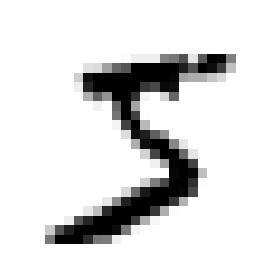

In [ ]:
# Cette syntaxe ne fonctionne pas pour extraire en tant que tableau la ligne 0 d'un DataFrame pandas
# J'ai donc utilisé la méthode un peu bourrin juste en dessous
some_digit = X.iloc[0].to_numpy()
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [15]:
y[0]

'5'

Le label est un `string`, donc il faut le *cast* en `integer` :

In [16]:
y = y.astype(np.uint8)
y[0]

5

Le JdD MNIST est déjà découpé avec son JdE (les 60000 premières images) et son JdT (les dernières 10000 images):

In [17]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Le JdE a déjà été mélangé, ce qui est une bonne chose puisque cela nous garanti que les blocs (*folds*) de validation croisée seront similaires (on ne voudrait pas qu'un bloc ne dispose pas d'un type de chiffre). De plus, certains algo d'apprentissage son sensibles à l'ordre d'entraînement des instacnes, et ont de mauvaises performances s'ils ont plusieurs instances similaires dans une ligne. Mélanger (*shuffle*) le JdD assure que cela n'arrive pas.

## Entraîner un classificateur binaire (*binary classification*)

On va simplifier le problème pour l'instant, et essayer de n'identifier qu'un seul chiffre : le 5.
Ce détecteur de 5 sera un classificateur binaire, capable de distinguer deux classes uniquement : "5" et "pas 5".

On crée le vecteur cible pour cette tâche de classification :

In [18]:
y_train_5 = (y_train == 5) # True pour tous les 5, False pour tous les autres chiffres
y_test_5 = (y_test == 5)

Maintenant, on va choisir un classificateur et l'entraîner.

Un bon point de départ est le classificateur *Stochastic Gradient Descent* (`SGD` - Gradient de descente stochastique), qu'on peut utiliser avec la classe *Scikit-Learn* `SGDClassifier`. Il a l'avantage d'être **capable de gérer de très grand JdD efficacement**. C'est en parti dû au fait que SGD **gère les instances d'entraînement indépendemment, une à la fois** (ce qui le rend également **adapté au _online learning_**).

On va créer un classificateur `SGDClassifier` et l'entraîner avec tout je JdE :

In [19]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
# Si on veut des résultats reproductibles, il faut définir le paramètre random_state
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

On va maintenant l'utiliser pour détecter les images du chiffre 5 :µ

In [20]:
sgd_clf.predict([some_digit])

/home/remycosta/.local/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

Un message d'erreur inattendu suite à la conversion des données, c'est gênant, mais au final on le bon résultat puisqu'il a détecté que notre image représente un 5.

## Mesures de performances

Évaluer un classificateur est souvent beaucoup plus complexe qu'évaluer un régresseur (*regressor*), donc on va passer un certain temps là dessus.
Il y a beaucoup de mesures de performances disponibles, donc attention aux nouveaux concepts et acronymes.

### Mesurer la précision avec la validation croisée

Comme dans le chapitre 2, la validation croisée est une bonne manière d'évaluer un modèle

#### Implémenter la validation croisée

Parfois, on va avoir besoin de plus de contrôle sur le processus de validation croisée que ce que *Scikit-Learn* fournit à la volée. Le code suivant fait globalement la même chose que la fonction `cross_val_score()`, et print le même résultat :

In [21]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

KeyError: "None of [Int64Index([    1,     3,     4,     5,     7,     8,    10,    11,    12,\n               13,\n            ...\n            59984, 59985, 59987, 59988, 59989, 59991, 59993, 59994, 59996,\n            59998],\n           dtype='int64', length=40000)] are in the [columns]"

On a donc encore un truc qui ne marche pas ici, et ça a l'air plutôt compliqué de régler le problème, donc on va essayer la suite.

On va maintenant utiliser la fonction `cross_val_score()` pour évaluer notre modèle `SGDClassifier`, en utilisant une validation croisée à K-blocs, avec 3 blocs. On rappelle que la validation croisée en K-blocs divise le JdE en K blocs et fait ensuite des prédictions et les évalue sur chaque bloc en utilisant un modèle entraîné sur les autres blocs.

In [22]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

On obtient des résultats très intéressants, avec plus de 95% de précision. Avant de s'emballer, on va regarder un autre type de classificateur débile qui se contente juste de classifier chaque image dans la classe "pas 5" :

In [23]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

Observons la précision de ce modèle :

In [24]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

90% de précision : c'est simplement parce qu'environ 10% des images sont des 5, donc si on devine à chaque fois qu'une image n'est pas 5, on aura raison 90% du temps.

Cet exemple était pour montrer que la précision n'est généralement pas la mesure de performance préférée pour les classificateurs, particulièrement quand on travaille avec des JdD biaisés qui ont des classes beaucoup plus fréquentes que d'autres (*skewed datasets*).

### Matrice de confusion (*confusion matrix*)

Une bien meilleure manière d'évaluer la performance d'un classificateur est de regarder sa *matrice de confusion*. L'idée générale est de compter le nombre de fois que les instances d'une classe A sont classifiée comme classe B. Par exemple, pour connaître le nombre de fois qu'un classificateur a confondu les images de 5 avec des images de 3, on pourrait regarder dans la cinquième ligne, troisième colonne de la matrice de confusion.

Pour calculer la matrice de confusion, on a d'abord besoin d'un *jeu de prédictions qui peuvent être comparées au cibles (*targets*) réelles. On pourrait faire des prédictions sur le JdT, mais il vaut mieux le laisser intouché (rappel : on ne l'utilise qu'à la toute fin du projet, une fois qu'on a un classificateur prêt à être déployé).

À la place, on peut utiliser la fonction `cross_val_predict` :

In [25]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Comme la fonction cross_val_score, la fonction cross_val_predict va faire une validation croisée à k-blocs, mais au lieu de retourner le score d'évaluation, il va retourner les prédictions faites sur chaque bloc de test. Cela signifie qu'on va avoir une prédiction propre pour chaque instance dans le JdE ("propre" signifie que la prédiction est faire par un modèle qui n'a jamais vu les données durant l'entraînement).

On peut maintenant avoir la matrice de confusion, en utilisant la fonction `confusion_matrix()`. Il y a simplement besoin de lui passer les classes des cibles (*y_train_5*), et les classes des prédictions (*y_train_pred*) :

In [26]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Chaque ligne dans une matric de confusion représente *une vraie classe*, tandis que chaque colonne représente une *classe prédite*. La première ligne de cette matrice prend en considération les images "non 5" (la classe *négative*) : 53892 d'entre elles ont été correctement classifées en tant que "non 5" (**vrai négatifs**), tandis que les 687 restant ont été faussement claissifée en tant que 5 (**faux positif**). La seconde ligne prend en considération les images "5" : 1891  ont été faussement classifiées en tant que "non 5" (**faux négatif**), alors que 3530 ont été correctement classifées en tant que "5" (**vrai positif**). Un classificateur parfait n'aurait que des vrais positifs et des vrais négatifs, et donc la matrice de confusion n'aurait que des 0 dans sa diagonale principale (bas gauche, haut droit) :

In [27]:
y_train_prefect_predictions = y_train_5 # on prétend avoir atteint la perfection
confusion_matrix(y_train_5, y_train_prefect_predictions)

array([[54579,     0],
       [    0,  5421]])

La matrice de confusion donne beaucoup d'informations, mais il est parfois préférable d'avoir des mesures précises. Une mesure intéressante à regarder est la précision des prédictions positives, appeléé `précision` par le classificateur :

$$
precision = \frac{TP}{TP+FP}
$$

- TP = nombre de Vrai Positifs
- FP = nombre de Faux Positifs

Un moyen très facile d'obtenir une précision de 100% est de faire une unique prédiction et de s'assurer qu'elle est correcte ($precision = 1/1 = 100%$). Mais cema ne serait pas très utile, puisque le classifictateur ingorerait tout sauf une unique instance positive. Donc la précision est liée à une autre mesure appelée le `rappel` (`recall`) ou `sensibilité` (ou encore *True positive rate*, TRP) : c'est le ratio d'instances positives qui sont correctement détectées par le classificateur :

$$
recall = \frac{TP}{TP + FN}
$$

- FN : Faux Négatif

### Précision et rappel (*precision and recall*)

Scikit-Learn fournit plusieurs fonctions pour calculer les mesures des classificateurs, dont la précision et le rappel :

In [28]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [29]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

Notre détecteur de 5 n'est plus aussi glorieux que lors de notre première évaluation :
- Quand il prétend avoir détecté un 5, c'est correct dans 83% des cas
- Il ne détecte que 65% des 5

Il est souvent pratique de combiner la précision et le rappel dans une seule mesure appelée le `Score F1` (*F1 Score*), en particulier si on a besoin d'une manière simple de comparer deux classificateurs. Le score F1 est une *moyenne harmonique* (*harmonic mean*) de la précision et du rappel. Alors que la moyenne traite toutes les valeurs de manière égales, la moyenne harmonique donne beaucoup plus de poids aux valeurs faibles. De fait, le classificateur n'aura un score $F_1$ élevé si la précision et le rappel sont élevés.

$$
F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = \frac{precision * recall}{precision + recall} = \frac{TP}{TP + \frac{FN + FP}{2}}
$$

Pour calculer le score $F_1$, on peut simplement appeler la fonction `f1_score()` :

In [30]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

Le score $F_1$ favorise les calssificateurs qui ont une précision et un rappel similaire. Ce n'est pas toujours ce que l'on peut vouloir : dans certains contextes, on va surtout s'intéresser à la précision, et dans d'autres, on va surtout s'intéresser au rappel. Par exemple, si on a entraîné un classificateur à détecter des vidéos qui sont sûres pour les enfants, on va préférer un classificateur qui va rejeter beaucoup de bonnes vidéos (rappel bas), mais qui ne garde que les vidéos sûres (haute précision). Dans un autre contexte, si on entraîne un classificateur à détecter des voleurs à l'étalage dans des images de surveillance, on va préférer un classificateur avec une précision faible mais avec un rappel élevé (il y aura des fausses alertes, mais tout le monde va se faire attraper).

Malheureusement, on ne peut pas avoir les deux en même temps : augmenter la précision diminue le rappel, et inversement. C'est ce qu'on appelle le compromis précision/rappel (*precision/recall tradeoff*)

### Compromis précision/rappel (*precision/recall tradeoff*)

Pour comprendre ce compromis, regardons comment le `SGDClassifier` prend ses décisions de classification. Pour chaque instance, il va calculer le score sur une *fonction de décision*. Si le score est plus grand que le seuil, il assigne l'instance dans la classe positive; sinon, il l'assigne dans la classe négative. Faire varier ce seuil va donc modifier la précision et le rappel en conséquence.

Scikit-Learn ne nous laisse pas modifier le seuil directement, mais permet d'avoir accès au score de décision qu'il utilise pour faire la précision. Au lieu d'appeler la méthode `predict()` du classificateur, on va appeler sa méthode `decision_function()` qui retourne un score pour chaque instance, et ensuite utilise chaque seuil qu'on veut pour faire des prédicitions basées sur ce score :

In [31]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

/home/remycosta/.local/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [33]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

`SGDClassifier` utilise un seuil égal à 0, donc le code précédent retourne le même résultat que la méthude `predict()` (c'est-à-dire True). On va maintenant augmenter le seuil :


In [34]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

Ceci confirme qu'augmenter le seuil diminue le rappel. L'image représente vraiment un 5, et le classficiateur la détecte quand le seuil est à 0, mais ne le fait pas quand le seuil est passé à 8000.

Comment décider quel seuil utiliser ? D'abord, on va utiliser la fonction `cross_val_predict()` pour obtenir le score de toutes les instances dans le JdE, mais cette fois *en précisant qu'on veut les scores de décision* au lieu des prédictions :

In [35]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

Avec ces scores, on va pouvoir utiliser la fonction `precision_recall_curve()` pour calculer la précision et le rappel pour tous les seuils possibles :

In [36]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Enfin, on va utiliser Matplotlib pour tracer la précision et le rappel comme des fonctions des valeurs du seuil :

Saving figure precision_recall_vs_threshold_plot


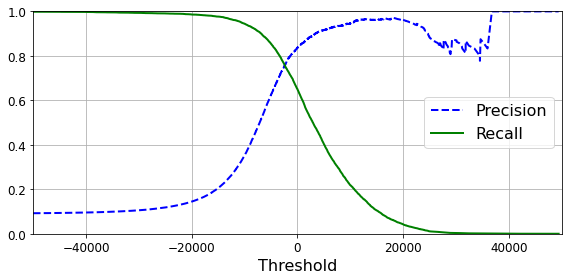

In [37]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown

plt.figure(figsize=(8, 4))                      # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
save_fig("precision_recall_vs_threshold_plot")  # Not shown
plt.show()

In [38]:
(y_train_pred == (y_scores > 0)).all()

True

Une autre manière de sélectionner un bon compromis entre précision et rappel, c'est de tracer directement la précision contre le rappel :

Saving figure precision_vs_recall_plot


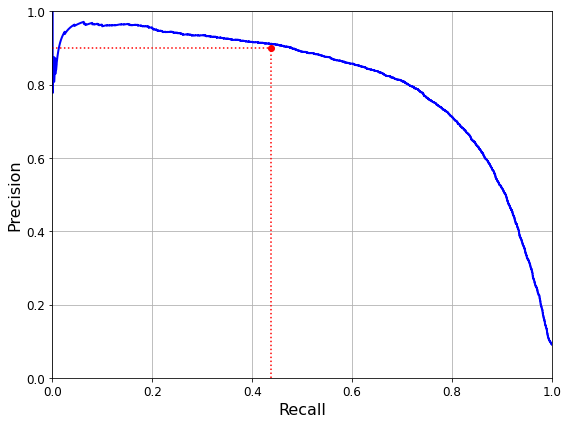

In [39]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()


On peut voir que la précision commence à chuter rapidement aux environs de 80% de rappel. Il peut donc être judicieux de choisir un compromis juste avant la chute, par exemple 60% de rappel. Encore une fois, le choix dépend du projet.

Supposons qu'on veuille 90% de précision. On va regarder le premier graphe et trouver qu'on a besoin d'un seuil aux alentours de 8000. Mais pour être plus précis, **on peut chercher le seuil le plus bas qui nous donne au moins la précision voulue** (`np.argmax()` va nous donner le premier index de valeur maximale, qui dans ce cas, veut dire le premier *True*).

In [40]:
threshold_90_precision = thresholds[np.argmax(precisions>=0.90)]
threshold_90_precision

3370.019499143957

Pour faire des prédictions (sur le JdE pour l'instant), plutôt que d'appeler la méthodes du classificateur `predict()`, on peut utiliser ceci :

In [41]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

Regardons maintenant la précision et le rappel de ces prédictions :

In [42]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [43]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

On a donc un classificateur à 90% de précision. Comme on peut voir, il est facile d'en créer un avec virtuellement la précision qu'on veut : il suffit de fixer un seuil.

Par contre, un classificateur très précis n'est pas très utile si le rappel est trop bas.

### La courbe ROC (*ROC Curve*)

La courbe *Receiver Operating Characteristic* (ROC - caractéristique de fonctionnement du récepteur, ou encore caractéristique de performance) est un autre outil souvent utilisé avec les classificateurs binaires. Elle est très similaire à la courbe précision/rappel, mais plutôt que de faire précsion vs rappel, elle va tracer le *true positive rate* (taux de vrais positifs, autre nom du rappel), contre le *false positive rate*(FPR - taux de faux positifs). Le FPR est le ratio des instance snégative squi ont été injustement classées positives. Il est égal à 1 - TNR (*True Negative Rate*, taux de vrai négatifs, donc les instances négatives correctement classées négatives). Le TNR est également appelé *spécificité*

La courbe ROC trace donc la *sensibilité* (rappel) contre $1 - spécificité$

Pour tracer la courbe ROC, on doit d'abord utiliser la fonction `roc_curve()` pour calculer les TPR et FPR pour plusieurs valeurs seuil :

In [44]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

On trace ensuite le FPR contre le TPR avec Matplotlib :

Saving figure roc_curve_plot


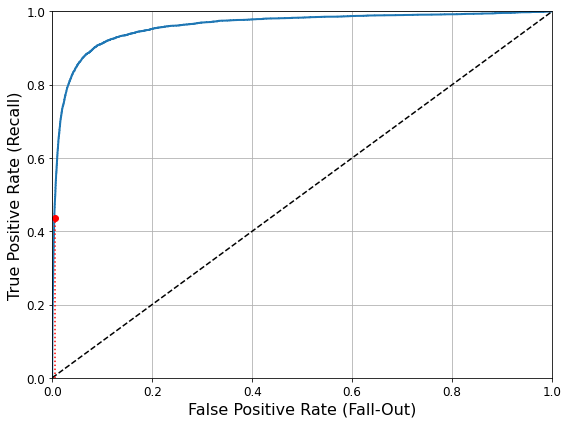

In [45]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0,1], 'k--')
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
save_fig("roc_curve_plot")                         # Not shown
plt.show()

Encore une fois, on peut voir le compromis : plus on augmente le rappel (TPR), plus le classificateur va produire de faux positifs (FPR). La ligne en pointillé représente la courbe ROC d'un classifictateur purement aléatoire ; **un bon classificateur reste le plus loin possible de cette ligne (en haut à gauche)**.

Une manière de **comparer les classificateur** est de *mesurer l'aire sous la courbe* (AUC - *Area Under Curve*). Un classificateur parfait a une ROC AUC égale à 1, alors qu'un classificateur purement aléatoire aurait une ROC AUC de 0.5. Scikit-Learn fournit une fonction qui permet de calculer l'AUC :

In [46]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

On va maintenant entraîner un `RandomForestClassifier` et comparer sa courbe ROC et son AUC à celles du `SGDClassifier`. D'abord, on va avoir besoin des scores pour chaque instance du JdE ; cependant, la classe `RandomForestClassifier` n'a pas de méthode `decision_function()`. À la place, elle a une méhtode `predict_proba()` qui retourne un tableau contenant une ligne par instance et une colonne par classe, chacun contenant la probablité que l'instance donnée appartienne à la classe donnée (par exemple : 70% de chance que l'image représente un 5) :

In [47]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

La fonction `roc_curve()` attend les labels et les scores, mais plutôt que les scores, on va lui donner des probabilités de classes. Utilisons la probabilité de classe positive comme score :

In [48]:
y_score_forest = y_probas_forest[:,1]   # score = proba de classe positive
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_score_forest)

On est maintenant prêt à tracer la courbe ROC. Il est utile de tracer la première courbe ROC également, pour pouvoir les comparer :

Saving figure roc_curve_comparison_plot


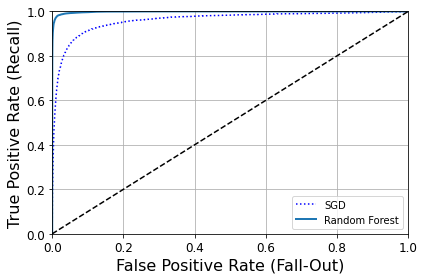

In [49]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
save_fig("roc_curve_comparison_plot")
plt.show()

La courbe ROC du `RandomForestClassifier` est bien meilleure que celle du `SGDClassifier`, parce qu'elle est beaucoup plus près du coin supérieur gauche. Son AUC sera donc également bien meilleur :

In [50]:
roc_auc_score(y_train_5, y_score_forest)

0.9983436731328145

Calcul de la précision :

In [51]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

Calcul du rappel :

In [52]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

On sait maintenant :
- Entraîner des classificateurs binaires;
- Sélectionner les mesures (*metrics*) appropriées pour la tâche;
- évaluer les classificateurs avec la validation croisée
- Sélection le compromis précision/rappel en fonction de nos besoins
- Utiliser les courbes ROC et le score AUC pour comparer les modèles

On va maintenant essayer de détecter plus que les 5.


## Classification multiclasse (*multiclass classification*)

Alors que les classificateurs binaires ne distinguent que deux classes, les *classificateurs multiclasses* (ou *multinomial classifiers*) peuvent en distinguer bien plus que deux.

Certains algo (classificateurs SGD, RF, Naive Bayes) sont capables de gérer nativement des multiples classes. D'autres (Régression Logisitique, SVM) sont strictements binaires. Cependant, il exsite des stratégies pour pouvoir réaliser des classifications multiclasses avec de multiples classificateurs binaires.

Une manière de créer un système qui peut classer les images en 10 classes (de 0 à 9) est d'entraîner 10 classificateurs, un pour chaque chiffre. Puis, quand on veut classer une image, on prend le score de décision de chaque calssificateur pour l'imagie et on sélectionela classe dont le classificateur a sorti le meilleur score. C'est ce qu'on appelle la stratégie *One-versus-the-Rest* (OvR) (aussi appelée *one-versus-all*).

Une autre stratégie est d'entraîner un classificateur pour chaque paire de chiffre : un qui distingue 0 et 1; un 0 et 2, et 1 et 2, etc. C'est la stratégie *One-versus-One* (OvO). S'il y a $N$ classes, on va avoir besoin d'entraîner $N*(N-1)/2$ classificateurs. Pour le problème MNIST, cela veut dire entraîner 45 classificateurs. Quand on veut classer une image, on doit la faire passer par 45 classificateurs et voir quelle classe gagne le plus de duels. L'avantage principal du OvO est que chaque classificateur a besoin d'être entraîné que sur la partie du JdE qui contient les deux classes qu'il doit distinguer.

Certains algo (Classificateurs SVM) évoluent mal avec la taille du JdE. Pour ces algo, le OvO est préférable parce qu'il est plus rapide d'entraîner plusieurs classificateurs sur des petits jeux, plutôt que d'entraîner quelques classificateurs sur des grands JdE. Pour la plupart des algo de classfication binaire, le OvR est préférable.

Scikit-Learn détexte quand on essaie d'utiliser un aglo de classification binaire pour une tâche de classification multiple, et va lancer automatique un OvR ou OvO, en fonction de l'algo.

On va essayer avec un SVM en utilisant la classe `sklearn.svm.SVC` :

In [53]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train) # on utilise bien y_train ici, et plus y_train_5
svm_clf.predict([some_digit])

/home/remycosta/.local/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

Ce code entraîne le SVC sur le JdE en utilisant les classes cibles d'origine de 0 à 9 (*y_train*) au lieu des classes cibles *5-versus-the-rest* (*y_train_5*). Puis, il va faire une prédiction. Sous le capot, Scikit-Learn utilise la stratégie OvO : il a entraîné 45 classificateurs binaires, obtenu leurs scores de décision pour les images, et sélectionné la classe qui a gagné le plus de duels.

Si on appelle la méthode `decision_function()`, on verra qu'il retourne 10 scores par instance (au lieu d'une seule). On a donc un score par classe :

In [ ]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

/home/remycosta/.local/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

Le score le plus haut est effectivement celui qui correspond à la classe 5 :

In [ ]:
np.argmax(some_digit_scores)


5

In [ ]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
svm_clf.classes_[5]

5

Attention : quand un classificateur est entraîné, il emmagasine la liste des classes cibles (*target classes*) dans son attribut `classes_`, ordonné par valeur. Dans ce cas, l'indice de chaque classe dans le tableau `classes_` correspond à la classe elle-même, mais en général on n'aura pas autant de chance.

Si on veut forcer Scikit-Learn à utiliser une stratégie OvO ou OvR, on peut utiliser les classes `OneVsOneClassifier` ou `OneVsRestClassifier`. Il faut simplement créer une instance et lui passer un classificateur dans son constructeur (ça ne doit pas forcément être un classificateur binaire).

Par exemple, ce code crée un classificateur multiclasse utilisant la stratégie OvR basé sur un SVC :

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

/home/remycosta/.local/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/home/remycosta/.local/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/home/remycosta/.local/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/home/remycosta/.local/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/home/remycosta/.local/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/home/remycosta/.local/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature 

array([5], dtype=uint8)

In [ ]:
len(ovr_clf.estimators_)

10

Entraîner un `SGDClassifier` ou un `RandomForestClassifier` est tout aussi simple :

In [ ]:
sgd_clf.fit(X_train, y_train)

AttributeError: 'SGDClassifier' object has no attribute 'prefdict'

In [ ]:
sgd_clf.predict([some_digit])

/home/remycosta/.local/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([3], dtype=uint8)

Cette fois, Scikit-Learn n'a pas eu à lancer un OvR ou un OvO parce que le classificateur SGD peut directement classer les instances en multiples classes. La méthode `decision_function()` retourne maintenant une valeur par classe. Regardons les socres que le classificateur SGD a assigné à chaque classe :

In [ ]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

/home/remycosta/.local/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

Ici on a une couille par rapport au livre : tous les scores sont très négatifs, sauf le 3. C'est totalement pourri et très certainement dû au problème de X qui n'a pas de nom de caractéristique valide ("*X does not have valid feature names*").

Le 5 est le moins négatif mais c'est vraiment pourri.

Dans le livre, on peut voir que le modèle a un doute sur la classe 3 qui a le score le moins négatif. Ici, c'est un peu comme si on avait inversé les deux.

In [ ]:
np.argmax(some_digit_scores)

3

Ça confirme bien qu'il prend le 5 pour un trois.

In [ ]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
sgd_clf.classes_[5]

5

Apparté : on essaie avec le OvO
